# Project Deliverable 3 - Group 33
#### Group Members: Bethany Findlay, Charlotte Albert, Kaykay Akpama, Kosi Udechukwu

## Notebook Set-Up

In [10]:
#Import necessary libraries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import metrics
from sklearn import inspection
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import PredictionErrorDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#Read cleaned data from past project deliverables
df=pd.read_csv("project_deliverable_1_cleaned.csv")

In [3]:
# Same feature engineering from deliverable 2
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df['pickup_minute'] = df['pickup_datetime'].dt.minute
df['pickup_time_fractional'] = df['pickup_hour'] + df['pickup_minute'] / 60

day_mapping = {
    'Monday': 0, 'Tuesday': 1, 'Wednesday': 2,
    'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6
}
df['pickup_day_num'] = df['pickup_day'].map(day_mapping)

## 1. Full Pipeline Construction

In [4]:
# Defining the feature set, using the expanded feature set from Deliverable 2

numeric_features = [
    'trip_distance_km',
    'pickup_day_num',
    'pickup_hour',
    'pickup_minute',
    'pickup_time_fractional',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude'
]

target = 'trip_duration'

In [5]:
# preprocessing with ColumnTransformer
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features)
    ]
)

StandardScaler puts all numeric features on a similar scale, helping models train more effectively. The ColumnTransformer is used so the preprocessing steps apply only to the selected numeric columns. This keeps the workflow clear and ensures the same steps are used during both training and testing.

In [6]:
# building 2 model pipelines (KNN Regression & Linear Regression)
linreg_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

knn_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", KNeighborsRegressor(n_neighbors=10))
])

The two model families selected for comparison are Linear Regression and KNN Regression, similarly to deliverable 2. Linear Regression provides a simple baseline model that is fast and easy to interpret. KNN Regression captures more complex patterns by looking at nearby datapoints.

In [7]:
# train/test split
X = df[numeric_features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [8]:
# fit and evaluate with RMSE, MAE, R^2
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return mae, rmse, r2

linreg_model.fit(X_train, y_train)
knn_model.fit(X_train, y_train)

linreg_metrics = evaluate(linreg_model, X_test, y_test)
knn_metrics = evaluate(knn_model, X_test, y_test)

The evaluation function uses MAE, RMSE, and R^2 because these three metrics give an overall view of the model performance for a regression task. MAE shows the average size of errors, RMSE penalizes larger mistakes more strongly, and R^2 shows how much the variation in trip duration the model can explain. Multiple metrics helps to compare multiple models against one another.

In [9]:
# print results for comparison
print("Linear Regression Results:")
print(f"MAE: {linreg_metrics[0]:.3f} secs")
print(f"RMSE: {linreg_metrics[1]:.3f} secs")
print(f"R^2: {linreg_metrics[2]:.3f}\n")

print("KNN Regression Results:")
print(f"MAE: {knn_metrics[0]:.3f} secs")
print(f"RMSE: {knn_metrics[1]:.3f} secs")
print(f"R^2: {knn_metrics[2]:.3f}")

Linear Regression Results:
MAE: 276.784 secs
RMSE: 407.309 secs
R^2: 0.604

KNN Regression Results:
MAE: 199.656 secs
RMSE: 316.123 secs
R^2: 0.761


## 2. Systematic Hyperparameter Tuning

### Principle Component Analysis
PCA is a linear dimensionality reduction techinque used to reduce the number of features in the dataset while still maintaining patterns or variance between features. KNN can suffer from the curse of dimensionality when given too many features and is quite computationally expensive when calculating the distances between all the points: this can be solved with PCA. 

In [ ]:
#Create a pipeline for the PCA test
pca_test_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ('pca', PCA()),
    ("knn", KNeighborsRegressor(n_neighbors = 10))
])

In [ ]:
#Test the model with 2, 4, 6, and 8 principal components
pca_param_grid = {
    "pca__n_components": [2, 4, 6, 8],
}

#Define scoring metrics
scoring = {
    "r2": "r2",
    "neg_mean_absolute_error": "neg_mean_absolute_error",
    "neg_root_mean_squared_error": "neg_root_mean_squared_error"
}

In [ ]:
#Perform GridSearchCV to find the best number of principal components
knn_tuning_pca = GridSearchCV(pca_test_pipeline, pca_param_grid, scoring = scoring, refit = "r2", cv=5, n_jobs=-1)
knn_tuning_pca.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('knn',
                                        KNeighborsRegressor(n_neighbors=10))]),
             n_jobs=-1, param_grid={'pca__n_components': [2, 4, 6, 8]},
             refit='r2',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'})

In [51]:
results_pca = pd.DataFrame(knn_tuning_pca.cv_results_)
show_pca = results_pca[[
    'param_pca__n_components',
    'mean_test_r2',
    'std_test_r2',
    'mean_test_neg_mean_absolute_error',
    'std_test_neg_mean_absolute_error',
    'mean_test_neg_root_mean_squared_error',
    'std_test_neg_root_mean_squared_error',
    'rank_test_r2'
]]

print(show_pca)

   param_pca__n_components  mean_test_r2  std_test_r2  \
0                        2      0.496397     0.001423   
1                        4      0.540889     0.001372   
2                        6      0.642717     0.001296   
3                        8      0.758019     0.001844   

   mean_test_neg_mean_absolute_error  std_test_neg_mean_absolute_error  \
0                        -324.403617                          0.891380   
1                        -308.025059                          0.593749   
2                        -264.329273                          0.564104   
3                        -201.856211                          0.353111   

   mean_test_neg_root_mean_squared_error  \
0                            -461.301273   
1                            -440.449864   
2                            -388.549917   
3                            -319.766580   

   std_test_neg_root_mean_squared_error  rank_test_r2  
0                              2.263628             4  
1         

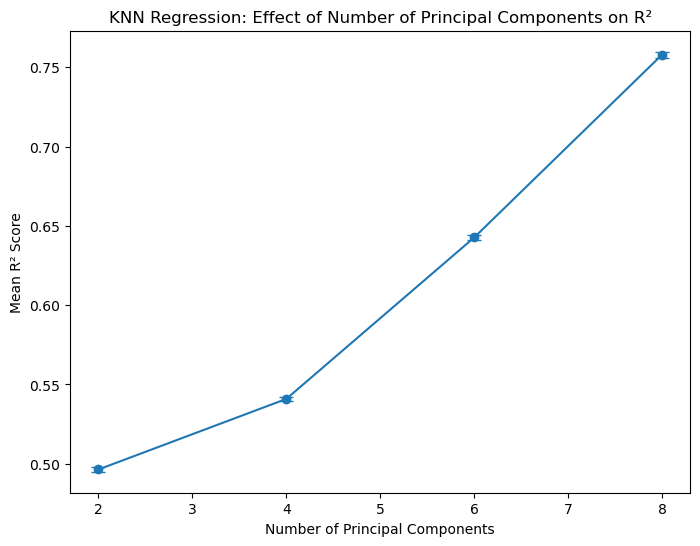

In [59]:
x_pca = results_pca["param_pca__n_components"]
y_pca = results_pca["mean_test_r2"]
y_err_pca = results_pca["std_test_r2"]

plt.figure(figsize=(8,6))
plt.errorbar(x_pca, y_pca, yerr=y_err_pca, fmt='-o', capsize=5)

plt.title("KNN Regression: Effect of Number of Principal Components on R²")
plt.xlabel("Number of Principal Components")
plt.ylabel("Mean R² Score")
plt.show()

PCA = 8 was the best performer across the board. It does have the largest standard deviation for R^2, but it is very negligible: PC = 6 has a std of 0.0012 while PC = 8 has a std of 0.0018. However, when comparing the MAE, RMSE, and R^2 with the results from above, the model performs best with no PCA applied. This is because are not a significant amount of features in the dataset for the curse of dimensionality to be a factor, for 1,458,644 records there are only 9 input features.

### Nearest Neighbors
The main hyperparameter in KNN is the number of nearest neighbors. This metric designates how many of the closest data points the model will consider when taking the average to make a prediction. In deliverable 2, it was found that 10 neighbors performed better than 5. Using more neighbors can help the model prevent overfitting. 

In [ ]:
#Create a pipeline for the n_neighbors test
nneighbors_test_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

In [ ]:
#Test the model with 10, 15, 20, and 25 neighbors
nneighbors_param_grid = {
    "knn__n_neighbors": [10, 15, 20, 25]
}

In [ ]:
#Perform GridSearchCV to find the best number of neighbors
knn_tuning_nneighbors = GridSearchCV(nneighbors_test_pipeline, nneighbors_param_grid, scoring = scoring, refit = "r2", cv=5, n_jobs=-1)
knn_tuning_nneighbors.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1, param_grid={'knn__n_neighbors': [10, 15, 20, 25]},
             refit='r2',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'})

In [52]:
results_nneighbors = pd.DataFrame(knn_tuning_nneighbors.cv_results_)
show_nneighbors = results_nneighbors[[
    'param_knn__n_neighbors',
    'mean_test_r2',
    'std_test_r2',
    'mean_test_neg_mean_absolute_error',
    'std_test_neg_mean_absolute_error',
    'mean_test_neg_root_mean_squared_error',
    'std_test_neg_root_mean_squared_error',
    'rank_test_r2'
]]

print(show_nneighbors)

   param_knn__n_neighbors  mean_test_r2  std_test_r2  \
0                      10      0.758019     0.001844   
1                      15      0.761444     0.001837   
2                      20      0.762244     0.001753   
3                      25      0.762012     0.001823   

   mean_test_neg_mean_absolute_error  std_test_neg_mean_absolute_error  \
0                        -201.856211                          0.353111   
1                        -200.118627                          0.389410   
2                        -199.749683                          0.379913   
3                        -199.948196                          0.386796   

   mean_test_neg_root_mean_squared_error  \
0                            -319.766580   
1                            -317.496028   
2                            -316.962878   
3                            -317.117782   

   std_test_neg_root_mean_squared_error  rank_test_r2  
0                              2.481206             4  
1              

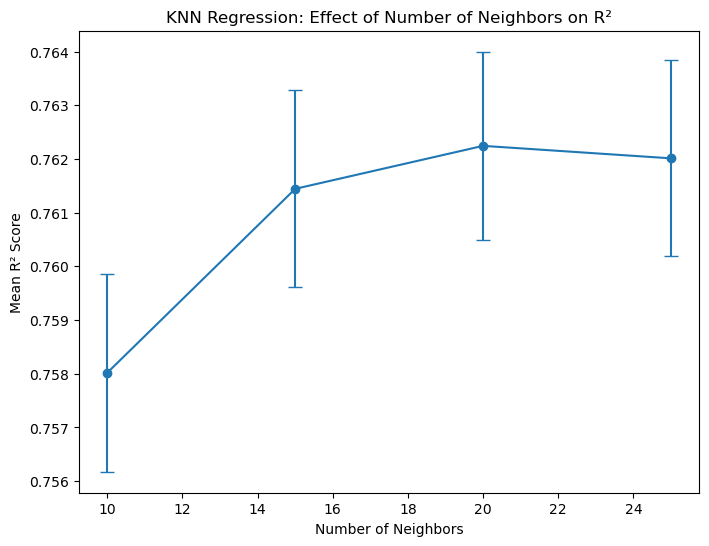

In [57]:
x_nneighbors = results_nneighbors["param_knn__n_neighbors"]
y_nneighbors = results_nneighbors["mean_test_r2"]
y_err_nneighbors = results_nneighbors["std_test_r2"]

plt.figure(figsize=(8,6))
plt.errorbar(x_nneighbors, y_nneighbors, yerr=y_err_nneighbors, fmt='-o', capsize=5)

plt.title("KNN Regression: Effect of Number of Neighbors on R²")
plt.xlabel("Number of Neighbors")
plt.ylabel("Mean R² Score")
plt.show()

Here we can see that 20 nearest neighbors performs the best across the board. This is likely because its preventing overfitting on the training data, and thus performs better on the data it hasn't seen. It should be noted that the standard deviation from MAE is only the second lowest while nneighbors = 10 has the lowest. However, for all other standard deviations it has the lowest scores.

### Weights
Now, another metric to adjust in KNN is the weighting metric. There are two options: uniform and metic. Uniform will give equal weight to all neighbors within the range. Distance will give more weight to closer neighbors. Distance versus uniform is a direct correlation to the bias versus variance tradeoff. The uniform weighting will reduce variance but increase bias and the distance weighting will reduce bias but increase variance.

It should be noted that previously in deliverable 2, the weights = distance made the train RMSE 0, this is because when training the model considers the distance from itself, and thus will perform "perfectly" on the training data. The more accurate measurement is on the performance when considering the test data. 

In [ ]:
#Create a pipeline for the weights test
weights_test_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor(n_neighbors=20))
])

In [ ]:
#Test the model with uniform versus distance weighting
weights_param_grid = {
    "knn__weights": ["uniform", "distance"]
}

In [48]:
#Perform GridSearchCV to find the best number weighting method
knn_tuning_weights = GridSearchCV(weights_test_pipeline, weights_param_grid, scoring = scoring, refit = "r2", cv=5, n_jobs=-1)
knn_tuning_weights.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn',
                                        KNeighborsRegressor(n_neighbors=20))]),
             n_jobs=-1, param_grid={'knn__weights': ['uniform', 'distance']},
             refit='r2',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'})

In [53]:
results_weights = pd.DataFrame(knn_tuning_weights.cv_results_)
show_weights = results_weights[[
    'param_knn__weights',
    'mean_test_r2',
    'std_test_r2',
    'mean_test_neg_mean_absolute_error',
    'std_test_neg_mean_absolute_error',
    'mean_test_neg_root_mean_squared_error',
    'std_test_neg_root_mean_squared_error',
    'rank_test_r2'
]]

print(show_weights)

  param_knn__weights  mean_test_r2  std_test_r2  \
0            uniform      0.762244     0.001753   
1           distance      0.764605     0.001811   

   mean_test_neg_mean_absolute_error  std_test_neg_mean_absolute_error  \
0                        -199.749683                          0.379913   
1                        -198.341127                          0.374711   

   mean_test_neg_root_mean_squared_error  \
0                            -316.962878   
1                            -315.385014   

   std_test_neg_root_mean_squared_error  rank_test_r2  
0                              2.419417             2  
1                              2.457451             1  


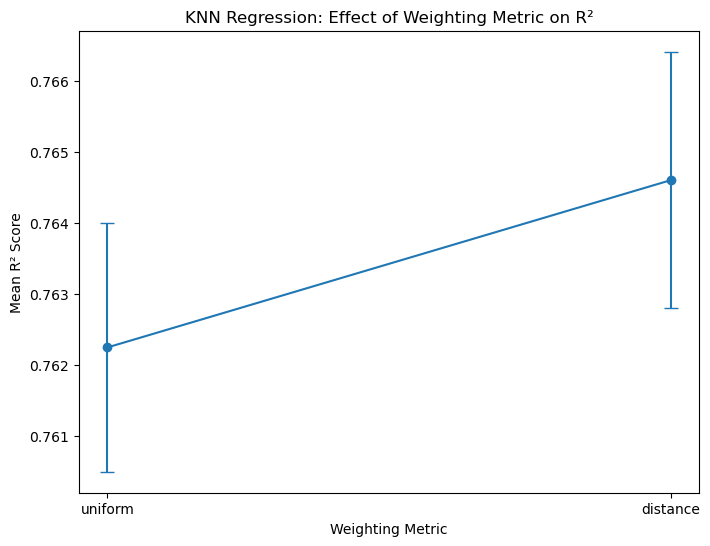

In [58]:
x_weights = results_weights["param_knn__weights"]
y_weights = results_weights["mean_test_r2"]
y_err_weights = results_weights["std_test_r2"]

plt.figure(figsize=(8,6))
plt.errorbar(x_weights, y_weights, yerr=y_err_weights, fmt='-o', capsize=5)

plt.title("KNN Regression: Effect of Weighting Metric on R²")
plt.xlabel("Weighting Metric")
plt.ylabel("Mean R² Score")
plt.show()

Across the board, the distance weights performed better. This is likely because the model can make more accurate predictions. With the number of neighbors being 20, if the weights are uniform, the model could be considering a point that is far away. The distance weighting helps solve that problem by giving more recognition to closer points. Uniform weighting does give lower standard deviations, but the differences are extremely small. 

In [61]:
#Build a simple, interpretable baseline model in scikit-learn
base_features=['trip_distance_km','pickup_hour','pickup_day_num']
target='trip_duration'
y = df[target]
X_base = df[base_features]

knn_pipe_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors = 5))
])

cv = KFold(n_splits=5, shuffle=True, random_state=42)

knn_baseline_results = cross_validate(
    knn_pipe_baseline,
    X_base,
    y,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

cv_table_knn_baseline = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(knn_baseline_results['test_r2']))],
    'R^2 Score': knn_baseline_results['test_r2'],
    'MAE (s)': -knn_baseline_results['test_neg_mean_absolute_error'],
    'MSE (s)': -knn_baseline_results['test_neg_mean_squared_error'],
    'train RMSE(s)': -knn_baseline_results['train_neg_root_mean_squared_error'],
    'test RMSE (s)': -knn_baseline_results['test_neg_root_mean_squared_error']
})

In [62]:
#Pipeline, cross validation and results DataFrame for KNN with new features
knn_tuned_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors = 20, weights='distance'))
])

knn_tuned_results = cross_validate(
    knn_tuned_pipe,
    X,
    y,
    cv=cv,
    scoring=['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'],
    return_train_score=True,
    n_jobs=-1
)

cv_table_knn_tuned = pd.DataFrame({
    'Fold': [f'Fold {i+1}' for i in range(len(knn_tuned_results['test_r2']))],
    'R^2 Score': knn_tuned_results['test_r2'],
    'MAE (s)': -knn_tuned_results['test_neg_mean_absolute_error'],
    'MSE (s)': -knn_tuned_results['test_neg_mean_squared_error'],
    'train RMSE(s)': -knn_tuned_results['train_neg_root_mean_squared_error'],
    'test RMSE (s)': -knn_tuned_results['test_neg_root_mean_squared_error']
})

In [65]:
#Extract metrics for all models
r2_knn_baseline = knn_baseline_results['test_r2']
mae_knn_baseline = -knn_baseline_results['test_neg_mean_absolute_error']
mse_knn_baseline = -knn_baseline_results['test_neg_mean_squared_error']
rmse_test_knn_baseline = -knn_baseline_results['test_neg_root_mean_squared_error']

r2_knn_tuned = knn_tuned_results['test_r2']
mae_knn_tuned = -knn_tuned_results['test_neg_mean_absolute_error']
mse_knn_tuned = -knn_tuned_results['test_neg_mean_squared_error']
rmse_test_knn_tuned = -knn_tuned_results['test_neg_root_mean_squared_error']

#Create comparison DataFrame for all models
comparison_df_base_vs_tuned = pd.DataFrame({
    'Metric': ['R^2', 'MAE (s)', 'MSE (s^2)', 'test RMSE (s)'],
    'KNN Baseline Model' : [r2_knn_baseline.mean(), mae_knn_baseline.mean(), mse_knn_baseline.mean(), rmse_test_knn_baseline.mean()],
    'KNN Tuned Model' : [r2_knn_tuned.mean(), mae_knn_tuned.mean(), mse_knn_tuned.mean(), rmse_test_knn_tuned.mean()]
})

print('KNN Regression: Baseline versus Tuned Model Comparion')
comparison_df_base_vs_tuned

KNN Regression: Baseline versus Tuned Model Comparion


,Metric,KNN Baseline Model,KNN Tuned Model
0,R^2,0.656548,0.767659
1,MAE (s),252.597570,196.536231
2,MSE (s^2),144867.220723,98004.953943
3,test RMSE (s),380.609482,313.048845


The comparison of the tuned model and the baseline show a significant difference for all evaluation metrics. The R^2 goes up by a little over 10%, MAE decreases by 55 seconds, MSE decreases by 46,863 seconds^2, and RMSE decreases by almost 70 seconds.

## 3. Final Model Selection and Evaluation

- nneighbors = 20
- weights = distance

## 4. Integration of TA Feedback

## 5. Final Reflection

## 6. Individual Contributions

## BONUS: Kaggle Submission